In [3]:
import sys
sys.path.append('/home/lenizio/datascience/diabetes_project')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import models 
import seaborn as sns
import tensorflow as tf
import sklearn
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, InputLayer 
from models import neural_network as nn
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, PolynomialFeatures





In [4]:
metrics = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='mse'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [5]:
def model_builder(hidden_layers, learning_rate_, lambda_,input_shape_, number_labels):   
    
    model = keras.Sequential()
    
    
    model.add(keras.Input(shape=(input_shape_)))
    
    for i in range(len(hidden_layers)):
        model.add(keras.layers.Dense(units=hidden_layers[i], activation='relu',
                                     kernel_regularizer=keras.regularizers.l2(lambda_))
                  )
    
    model.add(keras.layers.Dense(units=number_labels,
                                 kernel_regularizer=keras.regularizers.l2(lambda_))
              )       

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_),
                metrics=metrics
)
    return model

In [6]:
creditscore = pd.read_csv(r'/home/lenizio/datascience/diabetes_project/data/credit_score.csv')

In [7]:
credit_score = creditscore.copy()

In [8]:
credit_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 87 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CUST_ID                  1000 non-null   object 
 1   INCOME                   1000 non-null   int64  
 2   SAVINGS                  1000 non-null   int64  
 3   DEBT                     1000 non-null   int64  
 4   R_SAVINGS_INCOME         1000 non-null   float64
 5   R_DEBT_INCOME            1000 non-null   float64
 6   R_DEBT_SAVINGS           1000 non-null   float64
 7   T_CLOTHING_12            1000 non-null   int64  
 8   T_CLOTHING_6             1000 non-null   int64  
 9   R_CLOTHING               1000 non-null   float64
 10  R_CLOTHING_INCOME        1000 non-null   float64
 11  R_CLOTHING_SAVINGS       1000 non-null   float64
 12  R_CLOTHING_DEBT          1000 non-null   float64
 13  T_EDUCATION_12           1000 non-null   int64  
 14  T_EDUCATION_6            

In [9]:
credit_score.set_index('CUST_ID', inplace=True)

In [10]:
credit_score.CAT_GAMBLING.unique()

array(['High', 'No', 'Low'], dtype=object)

In [11]:
mapping = {'High': 2, 'No': 0, 'Low': 1}
credit_score.CAT_GAMBLING = credit_score.CAT_GAMBLING.replace(mapping)

In [12]:
columns_to_keep = [col for col in credit_score.columns if not  col.startswith('R_')]

In [13]:
credit_score = credit_score[columns_to_keep]

In [14]:
def plot_distributions(data_frame):
    
    plt.figure(figsize=(20,15,))

    for n, column in enumerate(data_frame.columns):        
        plt.subplot(5,7,n+1)
        plt.hist((data_frame[column].values) , label=column)
        plt.legend()

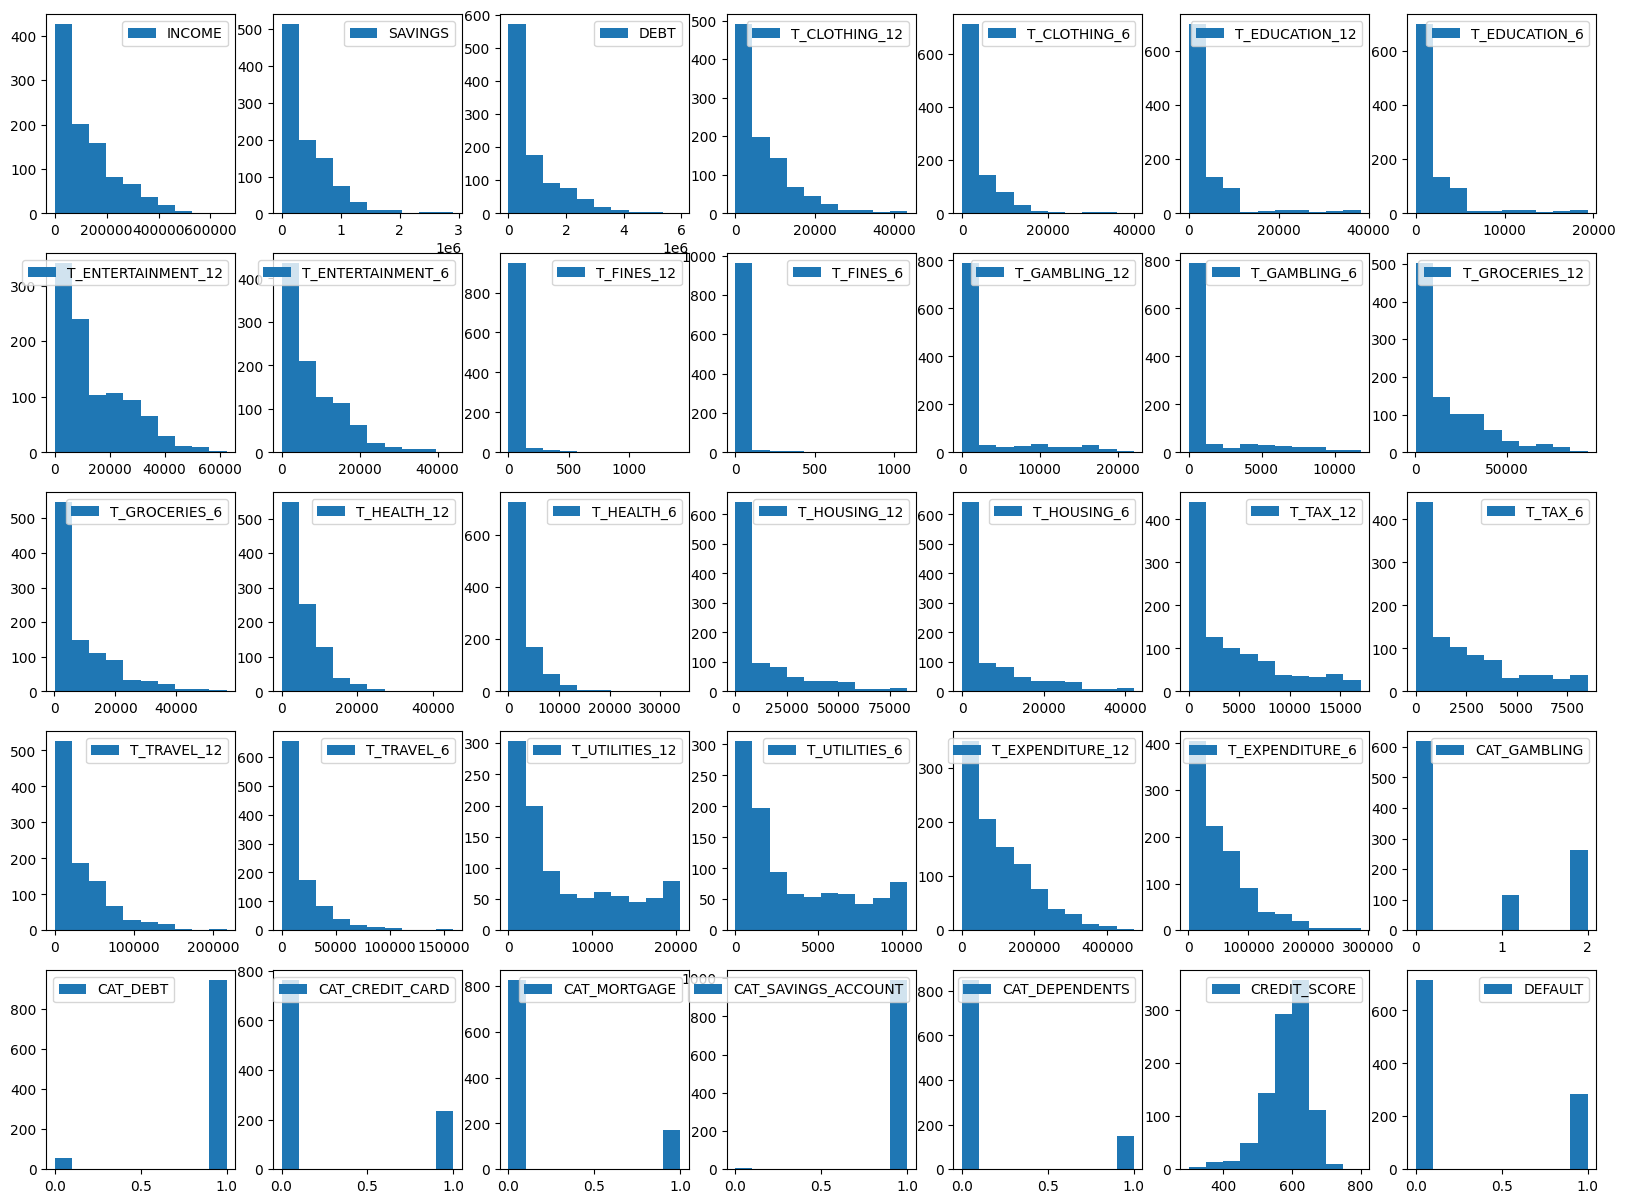

In [15]:
plot_distributions(credit_score)

In [16]:
credit_score.describe()

,INCOME,SAVINGS,DEBT,T_CLOTHING_12,T_CLOTHING_6,T_EDUCATION_12,T_EDUCATION_6,T_ENTERTAINMENT_12,T_ENTERTAINMENT_6,T_FINES_12,...,T_EXPENDITURE_12,T_EXPENDITURE_6,CAT_GAMBLING,CAT_DEBT,CAT_CREDIT_CARD,CAT_MORTGAGE,CAT_SAVINGS_ACCOUNT,CAT_DEPENDENTS,CREDIT_SCORE,DEFAULT
count,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,121610.019000,4.131896e+05,7.907180e+05,6822.401000,3466.320000,3604.26000,1811.460000,14261.255000,7945.307000,26.504000,...,104330.824000,54247.771000,0.644000,0.944000,0.236000,0.173000,0.993000,0.15000,586.712000,0.284000
std,113716.699591,4.429160e+05,9.817904e+05,7486.225932,5118.942977,7065.70035,3551.440702,12388.187688,7374.463757,136.171755,...,89250.193047,49853.939283,0.870645,0.230037,0.424835,0.378437,0.083414,0.35725,63.413882,0.451162
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,1177.000000,620.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,300.000000,0.000000
25%,30450.250000,5.971975e+04,5.396675e+04,1084.500000,319.500000,0.00000,0.000000,4248.750000,2289.000000,0.000000,...,30216.750000,15768.500000,0.000000,1.000000,0.000000,0.000000,1.000000,0.00000,554.750000,0.000000
50%,85090.000000,2.738505e+05,3.950955e+05,4494.000000,1304.000000,0.00000,0.000000,9401.000000,5003.500000,0.000000,...,80639.000000,40898.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.00000,596.000000,0.000000
75%,181217.500000,6.222600e+05,1.193230e+06,10148.500000,4555.500000,5189.25000,2611.000000,22892.500000,12304.750000,0.000000,...,155325.000000,78459.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.00000,630.000000,1.000000
max,662094.000000,2.911863e+06,5.968620e+06,43255.000000,39918.000000,38229.00000,19327.000000,62529.000000,44066.000000,1421.000000,...,472924.000000,286987.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,800.000000,1.000000


In [17]:
### Aplying log transformation to reduce range of values
clean_cs = credit_score.copy()
columns_to_normalize = [column for column in credit_score.columns if not column.startswith('CAT_')]
eps= 0.001
for col in columns_to_normalize:
    clean_cs['LOG_'+col] = np.log(clean_cs.pop(col)+eps)


In [18]:
clean_cs.describe()   

,CAT_GAMBLING,CAT_DEBT,CAT_CREDIT_CARD,CAT_MORTGAGE,CAT_SAVINGS_ACCOUNT,CAT_DEPENDENTS,LOG_INCOME,LOG_SAVINGS,LOG_DEBT,LOG_T_CLOTHING_12,...,LOG_T_TAX_12,LOG_T_TAX_6,LOG_T_TRAVEL_12,LOG_T_TRAVEL_6,LOG_T_UTILITIES_12,LOG_T_UTILITIES_6,LOG_T_EXPENDITURE_12,LOG_T_EXPENDITURE_6,LOG_CREDIT_SCORE,LOG_DEFAULT
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.644000,0.944000,0.236000,0.173000,0.993000,0.15000,10.357295,11.858457,11.522096,7.398558,...,5.026429,4.466203,6.633177,5.973294,7.564718,6.910921,11.071964,10.390292,6.368051,-4.945669
std,0.870645,0.230037,0.424835,0.378437,0.083414,0.35725,4.112122,2.420824,4.805565,3.578517,...,5.928167,5.664962,6.995780,6.692377,3.518315,3.376977,1.132320,1.158011,0.117401,3.116971
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-6.907755,-6.907755,-6.907755,-6.907755,...,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,7.070725,6.429721,5.703786,-6.907755
25%,0.000000,1.000000,0.000000,0.000000,1.000000,0.00000,10.323848,10.997417,10.896104,6.988875,...,5.347112,4.675098,8.567553,7.240612,7.320857,6.633977,10.316145,9.665767,6.318519,-6.907755
50%,0.000000,1.000000,0.000000,0.000000,1.000000,0.00000,11.351463,12.520328,12.886883,8.410451,...,7.862493,7.164718,9.873930,9.036938,8.316423,7.627301,11.297738,10.618834,6.390242,-6.907755
75%,2.000000,1.000000,0.000000,0.000000,1.000000,0.00000,12.107452,13.341113,13.992172,9.225081,...,8.816223,8.118356,10.791975,10.083875,9.340294,8.654604,11.953275,11.270331,6.445721,0.001000
max,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,13.403163,14.884304,15.602026,10.674868,...,9.741733,9.049820,12.285609,11.975325,9.928375,9.241451,13.066690,12.567192,6.684613,0.001000


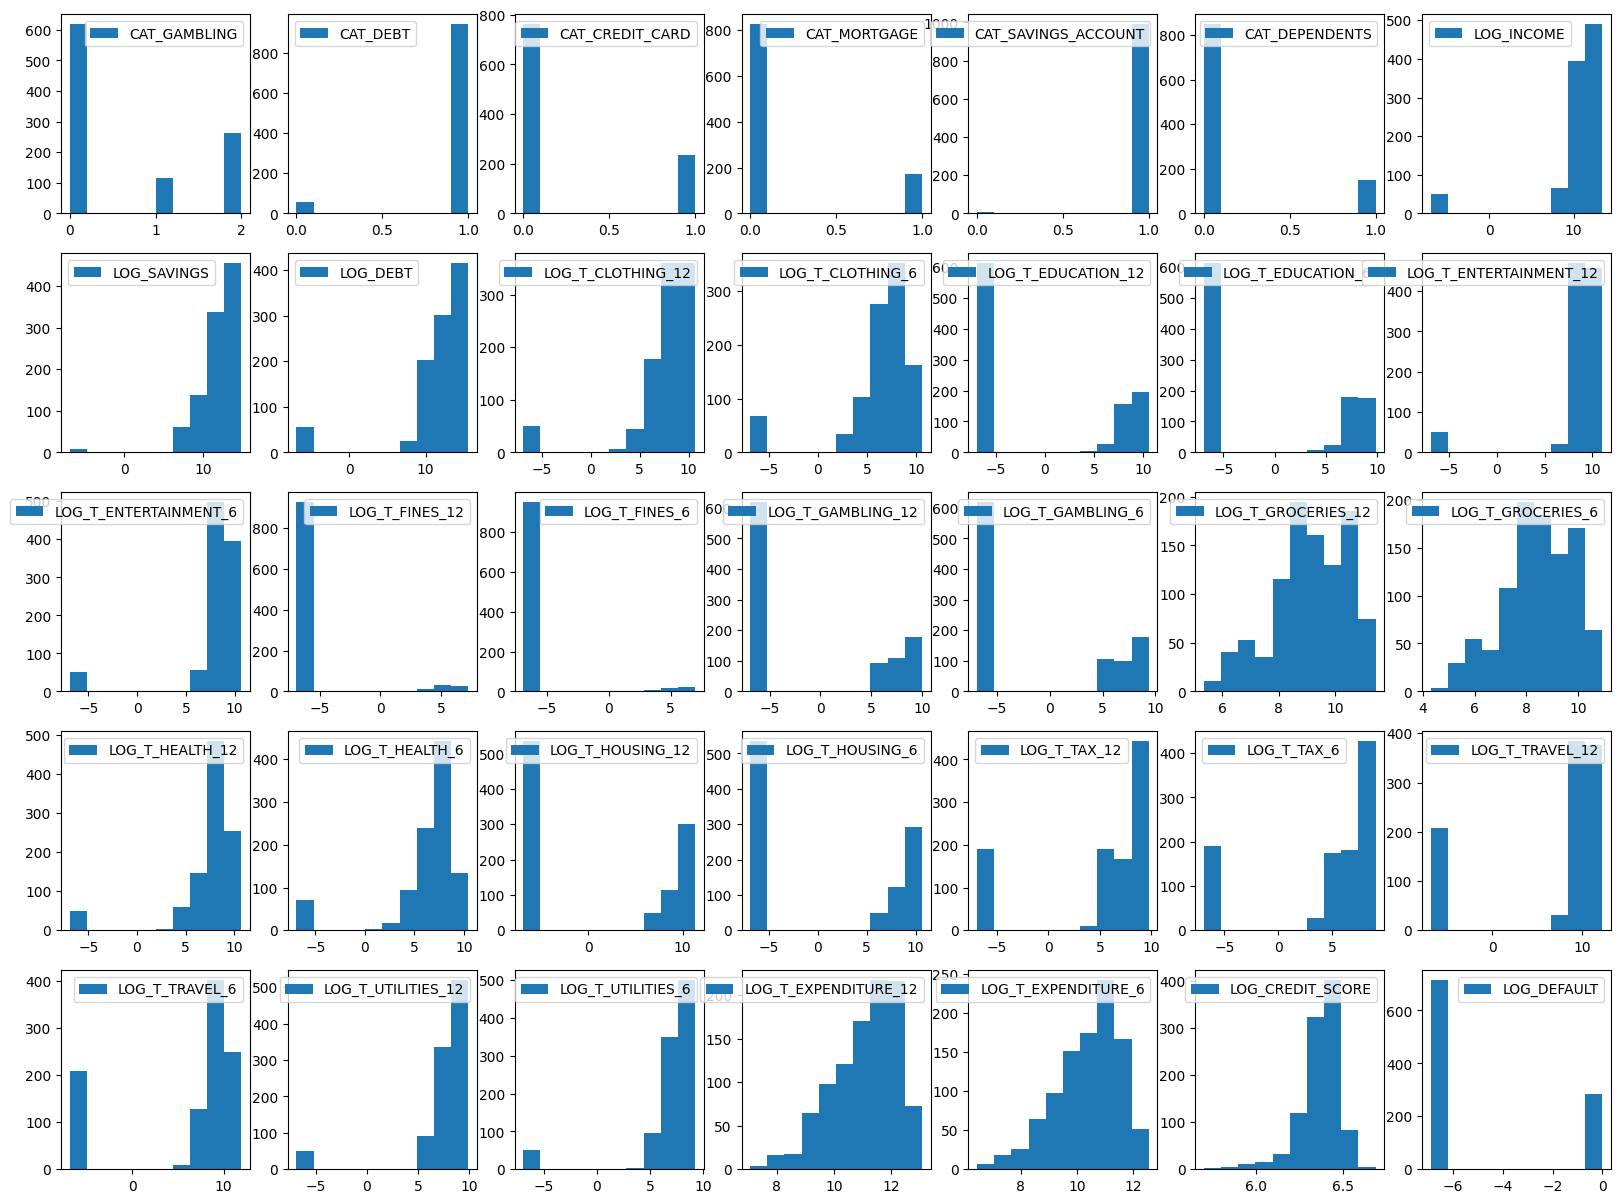

In [19]:
plot_distributions(clean_cs)

In [20]:
###Spliting and normalizing data before log transformation
X = credit_score.iloc[:, 0 :33].values
Y=credit_score.iloc[:,-1].values

X_train, x_, Y_train, y_ = train_test_split(X, Y, test_size = 0.40 )
x_cv, x_test, y_cv, y_test =train_test_split(x_,y_, test_size=0.50) 

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
x_cv = scaler.transform(x_cv)
x_test = scaler.transform(x_test)


In [21]:
###Spliting and normalizing data after log transformation
X_clean = credit_score.iloc[:, 0 :33].values
Y_clean=credit_score.iloc[:,-1].values

X_train_clean, x_clean, Y_train_clean, y_clean = train_test_split(X, Y, test_size = 0.40 )
x_cv_clean, x_test_clean, y_cv_clean, y_test_clean =train_test_split(x_clean,y_clean, test_size=0.50) 

X_train_clean = scaler.fit_transform(X_train_clean)
x_cv_clean = scaler.transform(x_cv_clean)
x_test_clean = scaler.transform(x_test_clean)

In [22]:
model = model_builder([60,30,16],0.001,0.01 ,(33,),1)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                2040      
                                                                 
 dense_1 (Dense)             (None, 30)                1830      
                                                                 
 dense_2 (Dense)             (None, 16)                496       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4383 (17.12 KB)
Trainable params: 4383 (17.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
history = model.fit(X_train,Y_train, epochs=100, validation_data=(x_cv,y_cv))

Epoch 1/100
19/19 [==============================] - 4s 75ms/step - loss: 1.6331 - cross entropy: 4.0681 - mse: 0.9093 - tp: 2.0000 - fp: 1.0000 - tn: 434.0000 - fn: 163.0000 - accuracy: 0.7267 - precision: 0.6667 - recall: 0.0121 - auc: 0.4960 - prc: 0.2835 - val_loss: 1.6014 - val_cross entropy: 4.8589 - val_mse: 1.7640 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 137.0000 - val_fn: 63.0000 - val_accuracy: 0.6850 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.3150
Epoch 2/100
19/19 [==============================] - 0s 11ms/step - loss: 1.4935 - cross entropy: 4.2419 - mse: 1.6256 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 435.0000 - fn: 165.0000 - accuracy: 0.7250 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.2750 - val_loss: 1.4922 - val_cross entropy: 4.8589 - val_mse: 1.8577 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 137.0000 - val_fn: 63.0000 - val_accuracy: 0.6850 - val_precision: 0.0000e+00 - val_recall: 0

In [25]:
pred= model.predict(x_test)
predictions = tf.nn.sigmoid(pred).numpy()


7/7 [==============================] - 0s 2ms/step


In [26]:
evaluation = model.evaluate(x_test,y_test)

7/7 [==============================] - 0s 6ms/step - loss: 0.7102 - cross entropy: 3.1808 - mse: 2.4393 - tp: 1.0000 - fp: 1.0000 - tn: 143.0000 - fn: 55.0000 - accuracy: 0.7200 - precision: 0.5000 - recall: 0.0179 - auc: 0.5992 - prc: 0.4225           


In [27]:
for name, value in zip(model.metrics_names, evaluation):
  print(name, ': ', value)

loss :  0.7101765275001526
cross entropy :  3.180783271789551
mse :  2.4392945766448975
tp :  1.0
fp :  1.0
tn :  143.0
fn :  55.0
accuracy :  0.7200000286102295
precision :  0.5
recall :  0.01785714365541935
auc :  0.5992063879966736
prc :  0.42249056696891785


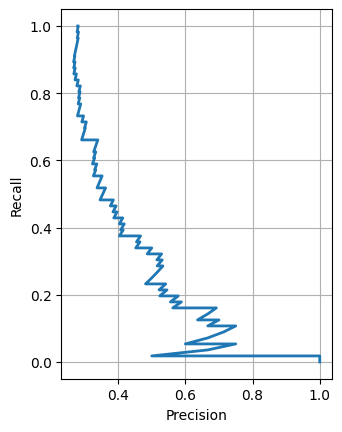

In [28]:

precision, recall, threshold= sklearn.metrics.precision_recall_curve(y_test, predictions)

plt.plot(precision, recall, label=name, linewidth=2)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal')

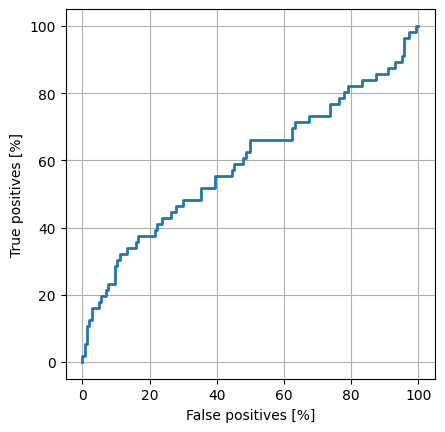

In [30]:
fp, tp, th = sklearn.metrics.roc_curve(y_test, predictions)

plt.plot(100*fp, 100*tp, label=name, linewidth=2)
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal')

In [33]:
model_clean = model_builder([60,30,16],0.001,0.01 ,(33,),1)

In [34]:
history_clean = model.fit(X_train_clean,Y_train_clean, epochs=100, validation_data=(x_cv_clean,y_cv_clean))

Epoch 1/100
 1/19 [>.............................] - ETA: 0s - loss: 0.7206 - cross entropy: 4.5472 - mse: 2.6190 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 20.0000 - fn: 12.0000 - accuracy: 0.6250 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6021 - prc: 0.5626

19/19 [==============================] - 0s 11ms/step - loss: 0.6468 - cross entropy: 3.8068 - mse: 2.4402 - tp: 9.0000 - fp: 5.0000 - tn: 415.0000 - fn: 171.0000 - accuracy: 0.7067 - precision: 0.6429 - recall: 0.0500 - auc: 0.5752 - prc: 0.4156 - val_loss: 0.5802 - val_cross entropy: 3.2876 - val_mse: 2.1576 - val_tp: 2.0000 - val_fp: 1.0000 - val_tn: 149.0000 - val_fn: 48.0000 - val_accuracy: 0.7550 - val_precision: 0.6667 - val_recall: 0.0400 - val_auc: 0.5704 - val_prc: 0.3909
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 0.6276 - cross entropy: 3.6774 - mse: 1.8971 - tp: 10.0000 - fp: 4.0000 - tn: 416.0000 - fn: 170.0000 - accuracy: 0.7100 - precision: 0.7143 - recall: 0.0556 - auc: 0.5894 - prc: 0.4397 - val_loss: 0.5925 - val_cross entropy: 3.3120 - val_mse: 1.7296 - val_tp: 1.0000 - val_fp: 1.0000 - val_tn: 149.0000 - val_fn: 49.0000 - val_accuracy: 0.7500 - val_precision: 0.5000 - val_recall: 0.0200 - val_auc: 0.5668 - val_prc: 0.3697
Epoch 3/100
19

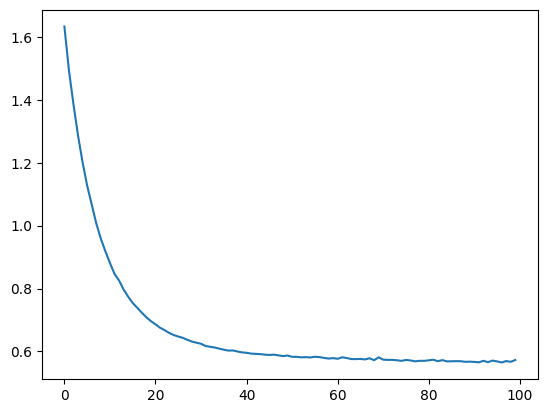

In [35]:
plt.plot(history.history['loss'])


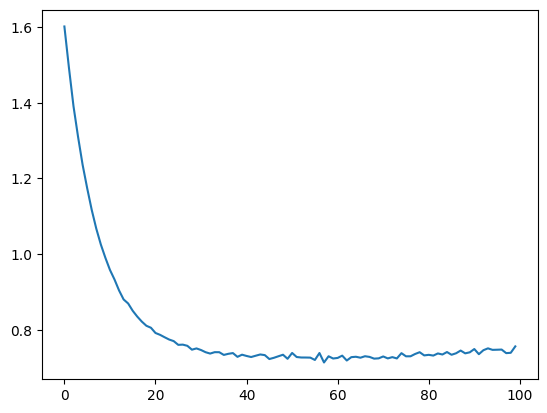

In [36]:
plt.plot(history.history['val_loss'])

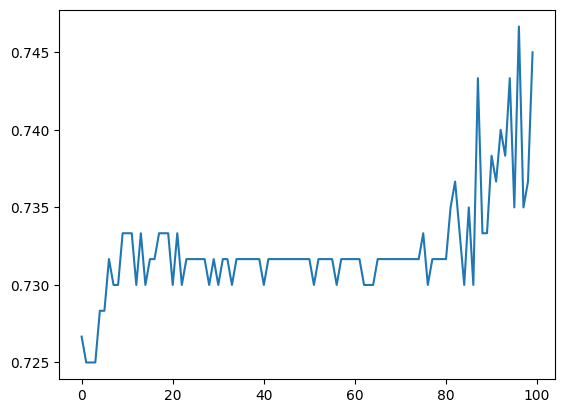

In [37]:
plt.plot(history.history['accuracy'])

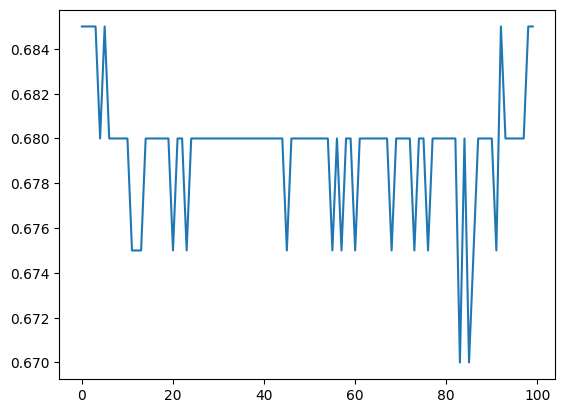

In [38]:
plt.plot(history.history['val_accuracy'])

In [ ]:
pred=model.predict(x_test)

7/7 [==============================] - 0s 5ms/step


In [ ]:
predictions = tf.nn.sigmoid(pred).numpy()

In [ ]:
predictions = np.where(predictions>=0.5,1,0)


In [ ]:
np.unique(predictions, return_counts=True)

(array([0, 1]), array([184,  16]))

In [ ]:
np.unique(Y_train, return_counts=True)

(array([0, 1]), array([423, 177]))

In [ ]:
test_loss, test_acc = model.evaluate(x_cv,  y_cv, verbose=2)


7/7 - 0s - loss: 0.6466 - accuracy: 0.7250 - 44ms/epoch - 6ms/step


In [ ]:
confusion_matrix(y_test,predictions)

array([[141,  11],
       [ 43,   5]])